# Rens' his place to play around in.

The contruction of DIS

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import DarkNews as dn

from DarkNews import pdg
from DarkNews import model as Theorymodel
import matplotlib.pyplot as plt

In [3]:
# targets
proton = dn.detector.NuclearTarget("H1")
C12    = dn.detector.NuclearTarget("C12")
Ar40   = dn.detector.NuclearTarget("Ar40")

model_vector_h   = dn.model.ThreePortalModel(name='heavy vector', m4 = 0.350, epsilon=1e-3, Umu4=1e-3, mzprime=1.25)

NC_test   = dn.model.ThreePortalModel(name='NC_test', m4 = 0.001, Umu4=1e-3, epsilon=0.0, gD=0.0)

#print(proton.__dict__)
#print(proton.mass)


Model:
	1 dirac heavy neutrino(s).
Model:
	1 dirac heavy neutrino(s).


In [4]:
#chosen_model = vector_h
chosen_model = NC_test

In [7]:
common_kwargs = {'nu_projectile': pdg.numu, 'scattering_regime': 'coherent', 'nuclear_target': C12}

#common_kwargs = {'nu_projectile': pdg.numu, 'nu_upscattered': pdg.neutrino4, 'helicity': 'conserving', 'nuclear_target': C12}
#scat_process   = dn.UpscatteringProcess(TheoryModel = chosen_model, scattering_regime = 'coherent', **common_kwargs) 
process_vector_h  = dn.UpscatteringProcess(TheoryModel = model_vector_h, nu_upscattered=model_vector_h.neutrino4, helicity = 'conserving',  **common_kwargs) 


In [8]:
Enu_range=np.linspace(0,2,200)

In [9]:
#import parton as lhapdf #credit LHAPDF
import lhapdf

In [10]:
#p = lhapdf.mkPDF('CT18NLO',0,pdfdir='../src/DarkNews/include/pdf_data/') for parton
pdf_path = '../src/DarkNews/include/pdf_data/'


In [11]:
Enu = 100

In [56]:
#class process():
#    def target(self):
#        self.Z= 1.25
#        self.M = proton.mass
Vij = process_vector_h.Vij # I thought it was a metric? I think its the V^2 of the vertex
print(Vij)

-0.0009999999626542427


In [33]:
 p = lhapdf.mkPDF("CT18NLO", 0) #allow user to choose +def-CT18? So it doesnt have to load it every int step
#p = lhapdf.mkPDF("CT18NLO", 0,pdfdir=pdf_path) #allow user to choose +def-CT18?
flavs = p.flavors()[1:-2]#d,u,s,c excluding b and gluon

LHAPDF 6.2.1 loading ../src/DarkNews/include/pdf_data/CT18NLO/CT18NLO_0000.dat
CT18NLO PDF set, member #0, version 1


In [45]:
def DIS(x_bj,y,Enu, process, TheoryModel, scattering_regime = 'DIS', diagrams=["total"]):

    target = process.target

    # masses
    M = target.mass
    #Z = target.Z atomic nr
    mHNL = process.m_ups
    mzprime = process.mzprime
    MSCALAR = process.mhprime
    #Enu = process.Enu
    #Enu=Enu
    Vhad = process.Vhad # Z' int with had
    Vij = process.Vij
    Vji = process.Vji
    #cfg = lhapdf.getConfig()
    #if target.is_proton == True: #set LHAPDF metadeta
    #    cfg.set_entry("Particle", 2212) #PID of target
    #elif target.is_neutron == True:
    #    cfg.set_entry("Particle", 2112)
    
    #del(cfg)
    #PDF reading
    #p = lhapdf.mkPDF("CT18NLO", 0) #allow user to choose +def-CT18?
    #p = lhapdf.mkPDF("CT18NLO", 0,pdfdir=pdf_path) #allow user to choose +def-CT18?
    #flavs = p.flavors()[1:-2]#d,u,s,c excluding b and gluon
    Q2 = x_bj*y*2*M*Enu
    f_half = 4
    R =0.3
    R_1 = 1/R #ratio for F_L should be calculated instead
    #zeros = np.zeros(f_half)
    
    g_Z2_V = np.zeros(f_half)
    g_Z2_A = np.zeros(f_half)
    
    g_Z1_V = np.zeros(f_half)
    g_Z1_A = np.zeros(f_half)
    
    g_Z2_V[0] =  g_Z2_V[2] = TheoryModel.ddV #down vectorial
    g_Z2_V[1] = g_Z2_V[3] =TheoryModel.duV #up vectorial
    g_Z2_A[0] =g_Z2_A[2]  = TheoryModel.ddA #down axial
    g_Z2_A[1] =g_Z2_A[3]=  TheoryModel.duA #up axial
    
    g_Z1_V[0] =  g_Z1_V[2] = TheoryModel.cdV #down vectorial
    g_Z1_V[1] = g_Z1_V[3] =TheoryModel.cuV #up vectorial
    g_Z1_A[0] =g_Z1_A[2]  = TheoryModel.cdA #down axial
    g_Z1_A[1] =g_Z1_A[3]=  TheoryModel.cuA #up axial
    
    
    def Lmunu_Hmunu_DC_SQR():
        xf = np.array(p.xfxQ2(flavs, x_bj, Q2))
        F2_Z2 = np.sum((g_Z2_V**2+g_Z2_A**2) *(xf[f_half:]+xf[:f_half]))
        xF3_Z2 = np.sum((2*g_Z2_V*g_Z2_A )*(xf[f_half:]-xf[:f_half]))
        FL_Z2= (R_1+1)*F2_Z2 
        x2F1_Z2 = F2_Z2*(1+4*M**2 * x_bj**2 /Q2)/(1+FL_Z2)
        y = Q2/( x_bj*2*M*Enu) 
        ds1 = 0.5*y**2 *x2F1_Z2 +(1-y-x_bj*y*M/(2*Enu))*F2_Z2 
        ds2 = y*(1-y*0.5)*xF3_Z2
        anti =1
        ds = (Vij*Vji)*(Vhad*Vhad) *M*Enu/(np.pi*(mzprime**2+Q2)**2) *(ds1+anti*ds2) #is all sqrt
        #print('ds',Vij)
        return(ds)#**2?
    Lmunu_Hmunu = {}
    Lmunu_Hmunu["DC_SQR"] = Lmunu_Hmunu_DC_SQR()
    #more dictionary and splitting over diagrams insert here

    return(Lmunu_Hmunu["DC_SQR"])

In [15]:
out  = DIS(0.003,100, Enu,process_vector_h, model_vector_h)


LHAPDF 6.2.1 loading ../src/DarkNews/include/pdf_data/CT18NLO/CT18NLO_0000.dat
CT18NLO PDF set, member #0, version 1
ds -0.0009999999626542427


In [16]:
#print(out.__dict__)
print(out)
print(out["DC_SQR"])

{'DC_SQR': 1.4137757654298622e-18}
1.4137757654298622e-18


In [ ]:
DIS_threshhold = 100

Now testing it with my mediocre int before building the real thing

def DIS(Q2, x_bj,process, TheoryModel, scattering_regime = 'DIS', diagrams=["total"]):


In [17]:

from scipy import integrate as sint



n = 10
E_nus = np.linspace(100,1000,n)
sigs_E = np.zeros(n)
err_sigs_E = np.zeros(n)
y_max =1
x_max =1
for i in range(n):
        x_min = mN**2/(2*mp*E_nus[i])
        sigs_E[i], err_sigs_E[i] =  sint.dblquad(ds_v,x_min,x_max,lambda x: mN**4/(8*mp*x*E_nus[i]**3),y_max, args = (E_nus[i]))



sig = sint.dblquad(ds_v,x_min,x_max,lambda x: mN**4/(8*mp*x*E**3),y_max, args = (np.array([Vert,E,anti])))

In [53]:
def integrand(E_nus, process, TheoryModel, scattering_regime = 'DIS'):
    target  = process.target
    M = target.mass
    #Z = target.Z atomic nr
    mHNL = process.m_ups
    n  = len(E_nus)
    sigs_E = np.zeros(n)
    err_sigs_E = np.zeros(n)
    y_max =1
    x_max =1
    for i in range(n):
        x_min = mHNL**2/(2*M*E_nus[i])
        sigs_E[i], err_sigs_E[i] =  sint.dblquad(DIS,x_min,x_max,lambda x: mHNL**4/(8*M*x*E_nus[i]**3),\
                                    y_max, args = (np.array([E_nus[i],process,TheoryModel])))

    return(sigs_E)








In [54]:
E_nus = np.linspace(100,400,20)
sigs = integrand(E_nus,process_vector_h,model_vector_h)

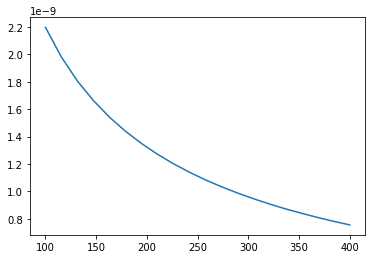

In [55]:
plt.plot(E_nus,sigs*3.89379372*10**(12)/E_nus)
plt.show()


    cfg = lhapdf.getConfig()
    if target.is_proton == True: #set LHAPDF metadeta
        cfg.set_entry("Particle", 2212) #PID of target
    elif target.is_neutron == True:
        cfg.set_entry("Particle", 2112)